In [1]:
import numpy as np
import pdb

### Deriving the ES Update

\begin{equation}
\nabla_{\theta} \mathbb{E}_{\epsilon \sim \mathcal{N}(0,I)} [F(\hat{\theta} + \sigma \epsilon )] \approx \dfrac{1}{\sigma} \mathbb{E}_{\epsilon \sim \mathcal{N}(0,I)} [ \epsilon \cdot F(\hat{\theta} + \sigma \epsilon )]
\end{equation}

where $\theta = \hat{\theta} + \sigma \epsilon$

#### Using the log-probability trick

\begin{align*}
\nabla_{\theta} \mathbb{E}_{\epsilon \sim \mathcal{N}(0,I)} [F(\hat{\theta} + \sigma \epsilon )] &= \\
&= \nabla_{\theta} \int_{\epsilon} p(\epsilon) F(\hat{\theta} + \sigma \epsilon ) d\epsilon \\
&= \int_{\epsilon} p(\epsilon) \nabla_\epsilon \log p(\epsilon) \nabla_\theta \epsilon F(\hat{\theta} + \sigma \epsilon ) d\epsilon & \scriptstyle{\text{chain rule on } \nabla_\theta p(\epsilon) \text{; I think we're ignoring the other half of the product rule}}\\
&= \mathbb{E}_{\epsilon \sim \mathcal{N}(0,I)} [\nabla_\epsilon \log p(\epsilon) \nabla_\theta \epsilon F(\hat{\theta} + \sigma \epsilon )] & \scriptstyle{\text{; Gaussian }p(\epsilon)=(2\pi)^{-\frac{n}{2}} \exp(-\frac{1}{2}\epsilon^\top\epsilon)} \\
&= \mathbb{E}_{\epsilon \sim \mathcal{N}(0,I)} [- \epsilon \nabla_\theta \big(\dfrac{\theta-\hat{\theta}}{\sigma}\big) F(\hat{\theta} + \sigma \epsilon )] \\
&= \mathbb{E}_{\epsilon \sim \mathcal{N}(0,I)} [- \epsilon \dfrac{1}{\sigma} F(\hat{\theta} + \sigma \epsilon )] \\
&= \dfrac{1}{\sigma} \mathbb{E}_{\epsilon \sim \mathcal{N}(0,I)} [\epsilon F(\hat{\theta} + \sigma \epsilon )]
\end{align*}

Notes: 
* I'm not sure why the negative sign goes away.
* If we do the other side of the chain rule we just get the expected gradient of F?
* The code normalizes $F(\hat{\theta} + \sigma \epsilon )$
* Which looks like batch/advantage normalization
* but also looks like the first order derivative approximation

\begin{equation}
F'(\hat{\theta} + \sigma \epsilon ) = \dfrac{F(\hat{\theta} + \sigma \epsilon )- F(\hat{\theta})}{\sigma \epsilon}
\end{equation}

In [2]:
# representing F as the score function for some quadratic function
# we negate it so it is an inverted parabola with peak at (0,0); the max score is 0

def F(fixed_w, x):
    res1 = fixed_w - x
    res2 = res1**2
    #pdb.set_trace()
    return -np.sqrt(np.sum((fixed_w - x)**2,axis=-1))

In [3]:
# main algorithm
# num_iters
# N = population size
# sigma - isotropic Gaussian std dev (a constant)
# mu - mean of p(x)

# for num_iters
# perturb mu to get N versions of it, using
# epsilon ~ N(0,I)
# x_perturbed = mu + sigma * epsilon
# evaluate F on all N versions
# normalize scores F
# update mu += epsion * F_normalized

In [4]:
num_iters = 300
N = 50
d = 3
fixed_w = np.array([0.1, -0.3, 0.5])
mu = np.random.randn(d)

sigma = 0.1
alpha = 0.001 # learning rate

for i in range(num_iters):
    # print current fitness of the most likely parameter setting
    if i % 20 == 0:
        print('iter %d. w: %s, solution: %s, reward: %f' % 
        (i, str(mu), str(fixed_w), F(fixed_w,mu)))
    noise = np.random.normal(size=(N,d))
    #print("noise: ", noise)
    x_guesses = mu + sigma*noise
    #print("guesses shape: ", x_guesses.shape)
    Fs = F(fixed_w, x_guesses)
    #print("Fs shape 1: ", Fs.shape)
    #print("Fs: ", Fs)
    
    # normalize scores
    # X = X - mu
    Fs_mean = np.mean(Fs)
    Fs = Fs - Fs_mean
    # compute sample std dev
    std_dev = np.sqrt(np.mean(Fs**2))
    Fs = Fs/std_dev
    
    """
    # where each row N[j] is weighted by A[j]
    w = w + alpha/(npop*sigma) * np.dot(N.T, A)
    """
    
    # compute update
    res1 = np.dot(noise.T,Fs)
    #print("Fs shape: ", Fs.shape)
    #print(res1.shape)
    mu += 1/(sigma*N)*alpha * res1


iter 0. w: [-0.97744872  0.7761016   0.58003808], solution: [ 0.1 -0.3  0.5], reward: -1.524892
iter 20. w: [-0.84037401  0.63583511  0.56575134], solution: [ 0.1 -0.3  0.5], reward: -1.328312
iter 40. w: [-0.70097617  0.49338333  0.56009275], solution: [ 0.1 -0.3  0.5], reward: -1.128996
iter 60. w: [-0.56593663  0.35650894  0.55192362], solution: [ 0.1 -0.3  0.5], reward: -0.936574
iter 80. w: [-0.42584579  0.22120984  0.53710116], solution: [ 0.1 -0.3  0.5], reward: -0.741316
iter 100. w: [-0.27953671  0.07912656  0.53450367], solution: [ 0.1 -0.3  0.5], reward: -0.537564
iter 120. w: [-0.14075322 -0.06097908  0.52146863], solution: [ 0.1 -0.3  0.5], reward: -0.339932
iter 140. w: [-0.01446415 -0.18969169  0.51409671], solution: [ 0.1 -0.3  0.5], reward: -0.159589
iter 160. w: [ 0.06625434 -0.26764334  0.49831683], solution: [ 0.1 -0.3  0.5], reward: -0.046782
iter 180. w: [ 0.09439009 -0.29012546  0.50471958], solution: [ 0.1 -0.3  0.5], reward: -0.012298
iter 200. w: [ 0.10322947 

In [5]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython import display
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'
%matplotlib inline

In [6]:
import os
import sys
import json
import time
import numpy as np
from random import shuffle

#### Code Comments

* optimizing on a 2d terrain
* the optimization landscape is a mixture of Gaussians


In [11]:
# generate a toy 2D regression dataset
sz = 100
X,Y = np.meshgrid(np.linspace(-1,1,sz),np.linspace(-1,1,sz))
print(X.shape)

(100, 100)


In [20]:
mux = 0.3
res = X - mux
print(res[0][0])

-1.3


In [21]:
print(1/2.0*2**2)

2.0


In [37]:
mux,muy,sigma=0.3,-0.3,4
#G1 = np.exp(-((X-mux)**2+(Y-muy)**2)/2.0*sigma**2)

G1 = np.exp(-((X[0][0]-mux)**2+(Y[0][0]-muy)**2)/2.0*sigma**2)
#print(G1)

# values between 0,1

# testing

val = ((X[0][0]-mux)**2+(Y[0][0]-muy)**2)/2.0
print(val)


# ohh, andrej is doing sigma as inverse of sigma
# why is he ignoring normalization
# ^ I still don't understand this but it's fine, we can move on

1.09


In [47]:
mux,muy,sigma=0.3,-0.3,4
#G1 = np.exp(-((X-mux)**2+(Y-muy)**2)/2.0*sigma**2)

G1 = np.exp(-((X-mux)**2+(Y-muy)**2)/2.0)
print(G1.min(), G1.max())
mux,muy,sigma=-0.3,0.3,2
G2 = np.exp(-((X-mux)**2+(Y-muy)**2)/2.0)
print(G2.min(), G2.max())
mux,muy,sigma=0.6,0.6,2
G3 = np.exp(-((X-mux)**2+(Y-muy)**2)/2.0)
print(G3.min(), G3.max())
mux,muy,sigma=-0.4,-0.2,3
G4 = np.exp(-((X-mux)**2+(Y-muy)**2)/2.0)
print(G4.min(), G4.max())

0.18451952399298924 0.9999500063512443
0.18451952399298924 0.9999500063512443
0.07730474044329971 0.9999836752684401
0.1826835240527347 0.999948986098723


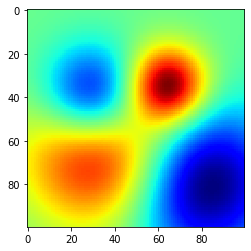

In [44]:

mux,muy,sigma=0.3,-0.3,4
#G1 = np.exp(-((X-mux)**2+(Y-muy)**2)/2.0*sigma**2)

G1 = np.exp(-((X-mux)**2+(Y-muy)**2)/2.0*sigma**2)

mux,muy,sigma=-0.3,0.3,2
G2 = np.exp(-((X-mux)**2+(Y-muy)**2)/2.0*sigma**2)
mux,muy,sigma=0.6,0.6,2
G3 = np.exp(-((X-mux)**2+(Y-muy)**2)/2.0*sigma**2)
mux,muy,sigma=-0.4,-0.2,3
G4 = np.exp(-((X-mux)**2+(Y-muy)**2)/2.0*sigma**2)

#G = G1 
G = G1 + G2 - G3 - G4
fig,ax = plt.subplots()
im = ax.imshow(G, cmap='jet')
#im = ax.imshow(G, vmin=-1, vmax=1, cmap='jet')
#plt.axis('off')

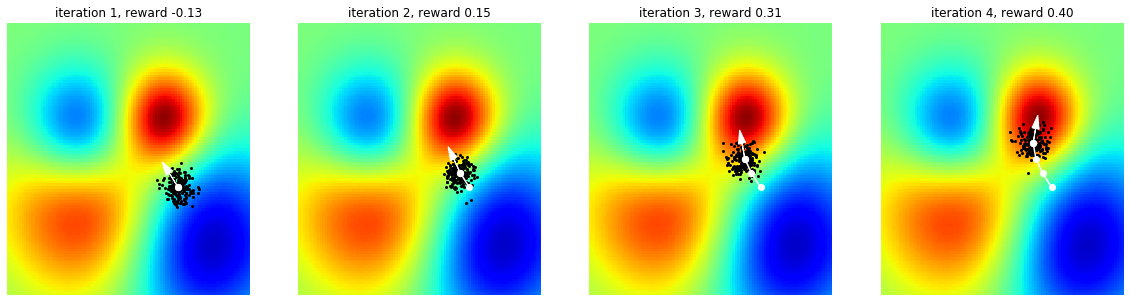

In [9]:
np.random.seed(3)
nn = 4 # number of steps to take (and plot horizontally)
alpha = 0.03 # learning rate
sigma = 3 # standard deviation of the samples around current parameter vector

w = np.array([70.0, 60.0]) # start point
plt.figure(figsize=(20,5))

prevx, prevy = [], []
for q in range(nn):
    
    # draw the optimization landscape
    ax1 = plt.subplot(1,nn,q+1)
    plt.imshow(G, vmin=-1, vmax=1, cmap='jet')

    # draw a population of samples in black
    noise = np.random.randn(200, 2)
    wp = np.expand_dims(w, 0) + sigma*noise
    x,y = zip(*wp)
    plt.scatter(x,y,4,'k', edgecolors='face')

    # draw the current parameter vector in white
    plt.scatter([w[0]],[w[1]],40,'w', edgecolors='face')

    # draw estimated gradient as white arrow
    R = np.array([G[int(wi[1]), int(wi[0])] for wi in wp])
    R -= R.mean()
    R /= R.std() # standardize the rewards to be N(0,1) gaussian
    g = np.dot(R, noise)
    u = alpha * g
    plt.arrow(w[0], w[1], u[0], u[1], head_width=3, head_length=5, fc='w', ec='w')
    plt.axis('off')
    plt.title('iteration %d, reward %.2f' % (q+1, G[int(w[0]), int(w[1])]))
    
    # draw the history of optimization as a white line
    prevx.append(w[0])
    prevy.append(w[1])
    if len(prevx) > 0:
        plt.plot(prevx, prevy, 'wo-')
    
    w += u
    plt.axis('tight')